##**Методы машинного обучения для оценки содержания азота в растениях по аэрофотоснимкам**

Этот блокнот предназначен для обучения нейросетевых методов машинного обучения.

**Подключение необходимых библиотек**

In [1]:
try:
    import torchmetrics
except ImportError:
    !pip install torchmetrics
    import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import gdown
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools

import torch
import torch.nn as nn
from torchmetrics.classification import JaccardIndex, Accuracy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from IPython.display import clear_output
import math

**Загрузка данных**

In [3]:
# синтетика с одного поля только
synth_url = 'https://drive.google.com/uc?id=1sqCezjdeC0eRgyktnuBHOcFYjy9Hq9SA'
test_url = 'https://drive.google.com/uc?id=1Rxxi3noANtl05UnXxGYZ_Iaa4Tl9lPCN'
synth_path = "train_images_and_masks.npz"
test_path = "test_images_and_masks.npz"
gdown.download(synth_url, synth_path, quiet=False)
gdown.download(test_url, test_path, quiet=False)
synth_data = np.load(synth_path)
test_data = np.load(test_path)
train_images = synth_data["synth_images"]
train_masks = synth_data["synth_masks"]
test_images = test_data["test_images"]
test_masks = test_data["test_masks"]

Downloading...
From (original): https://drive.google.com/uc?id=1sqCezjdeC0eRgyktnuBHOcFYjy9Hq9SA
From (redirected): https://drive.google.com/uc?id=1sqCezjdeC0eRgyktnuBHOcFYjy9Hq9SA&confirm=t&uuid=98ec244a-6fb9-461d-b8bc-e3b468a88f61
To: /content/train_images_and_masks.npz
100%|██████████| 321M/321M [00:06<00:00, 51.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Rxxi3noANtl05UnXxGYZ_Iaa4Tl9lPCN
To: /content/test_images_and_masks.npz
100%|██████████| 6.75M/6.75M [00:00<00:00, 23.8MB/s]


In [3]:
synth_url = 'https://drive.google.com/uc?id=1eCV1rbeVbh6TOEDxhXERE5yvivkrDtQr'
test_url = 'https://drive.google.com/uc?id=1Rxxi3noANtl05UnXxGYZ_Iaa4Tl9lPCN'
synth_path = "train_images_and_masks.npz"
test_path = "test_images_and_masks.npz"
gdown.download(synth_url, synth_path, quiet=False)
gdown.download(test_url, test_path, quiet=False)
synth_data = np.load(synth_path)
test_data = np.load(test_path)
train_images = synth_data["synth_images"]
train_masks = synth_data["synth_masks"]
test_images = test_data["test_images"]
test_masks = test_data["test_masks"]

Downloading...
From (original): https://drive.google.com/uc?id=1eCV1rbeVbh6TOEDxhXERE5yvivkrDtQr
From (redirected): https://drive.google.com/uc?id=1eCV1rbeVbh6TOEDxhXERE5yvivkrDtQr&confirm=t&uuid=e7b67d38-3204-4acb-8f2a-4138658a92fe
To: /content/train_images_and_masks.npz
100%|██████████| 322M/322M [00:02<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Rxxi3noANtl05UnXxGYZ_Iaa4Tl9lPCN
To: /content/test_images_and_masks.npz
100%|██████████| 6.75M/6.75M [00:00<00:00, 150MB/s]


Можно убрать канал RedEdge, без него модель обучается судя по всему лучше

In [4]:
train_images = np.delete(train_images, 2, axis=-1)
test_images = np.delete(test_images, 2, axis=-1)

**Проверка данных и визуализация изображений**

In [5]:
print(train_images.shape)
print(train_masks.shape)
print(test_images.shape)
print(test_masks.shape)

(3000, 128, 128, 5)
(3000, 128, 128, 1)
(66, 128, 128, 5)
(66, 128, 128, 1)


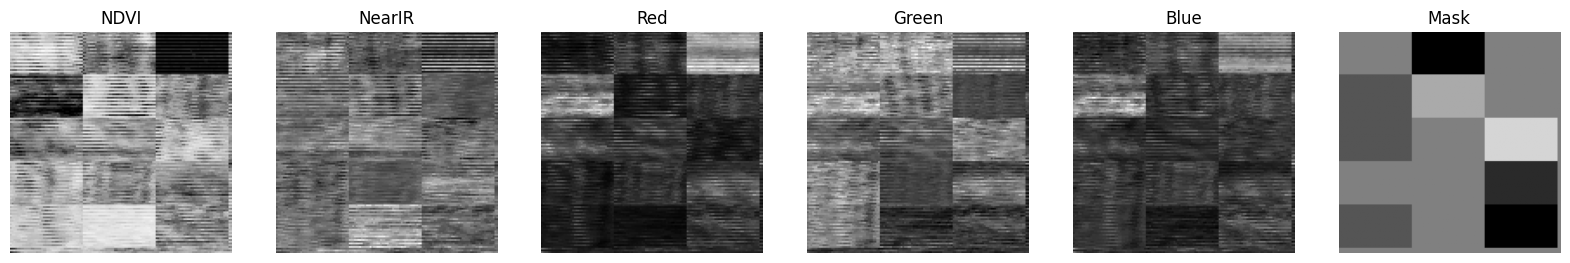

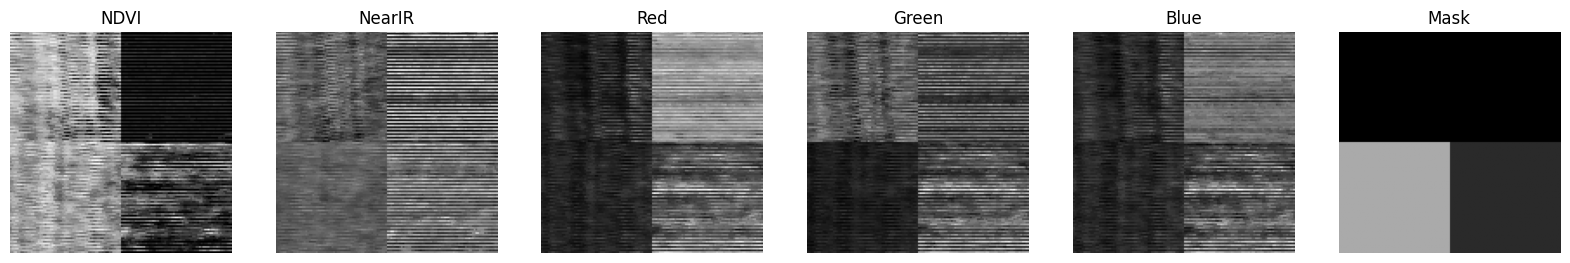

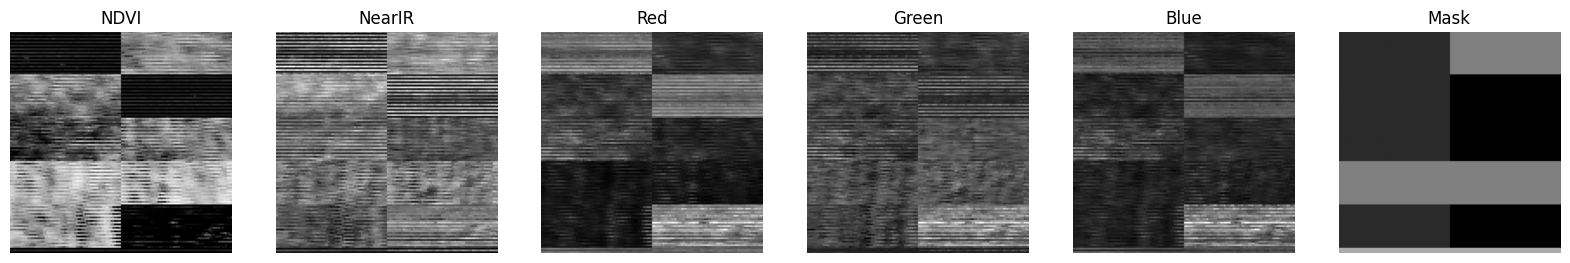

In [6]:
# Названия каналов для подписей
channel_names = ["NDVI", "NearIR", "Red", "Green", "Blue"]

def visualize_samples(images, masks, num_samples=3):
    """
    Визуализирует несколько примеров изображений и их масок.

    Параметры:
    - images: numpy-массив изображений (размерность: [N, 128, 128, 5])
    - masks: numpy-массив масок (размерность: [N, 128, 128, 1])
    - num_samples: количество примеров для отображения
    """

    for i in range(num_samples):
        img = images[i]  # Берём одно изображение (5 каналов)
        mask = masks[i].squeeze()  # Убираем лишнюю ось (128, 128)

        fig, ax = plt.subplots(1, 6, figsize=(20, 5))

        # Визуализируем все 5 каналов с подписями
        for j in range(5):
            ax[j].imshow(img[:, :, j], cmap="gray")
            ax[j].set_title(channel_names[j])  # Добавляем подпись
            ax[j].axis("Off")

        # Визуализируем маску (размеченные классы)
        ax[-1].imshow(mask, cmap="gray", vmin=0, vmax=6)
        ax[-1].set_title("Mask")
        ax[-1].axis("Off")

        plt.show()

# Вызываем функцию для отображения 3 примеров
visualize_samples(train_images, train_masks)

**Создание генераторов для аугментации изображений**

Для аугментации используются стандартные методы поворота до 90 градусов, смещения и отражения из библиотеки ImageDataGenerator.
Также мы выделяем валидационную выборку, которую будем использовать для контроля темпа обучения.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_masks, test_size=0.05, random_state=42
)

X_test = test_images
y_test = test_masks

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(2850, 128, 128, 5) (2850, 128, 128, 1)
(150, 128, 128, 5) (150, 128, 128, 1)
(66, 128, 128, 5) (66, 128, 128, 1)


In [8]:
data_gen_args = dict(
    rotation_range=90,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    horizontal_flip=True
)

train_image_datagen = ImageDataGenerator(**data_gen_args)
train_mask_datagen = ImageDataGenerator(**data_gen_args)
val_image_datagen = ImageDataGenerator()
val_mask_datagen = ImageDataGenerator()
test_image_datagen = ImageDataGenerator()
test_mask_datagen = ImageDataGenerator()

In [9]:
train_image_generator = train_image_datagen.flow(X_train, batch_size=32, seed=42)
train_mask_generator = train_mask_datagen.flow(y_train, batch_size=32, seed=42)
val_image_generator = val_image_datagen.flow(X_val, batch_size=32, seed=42)
val_mask_generator = val_mask_datagen.flow(y_val, batch_size=32, seed=42)
test_image_generator = test_image_datagen.flow(X_test, batch_size=32, shuffle=False, seed=42)
test_mask_generator = test_mask_datagen.flow(y_test, batch_size=32, shuffle=False, seed=42)

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2850, 128, 128, 5) (5 channels).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (150, 128, 128, 5) (5 channels).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (66, 128, 128, 5) (5 chann

Объединяем генератор для изображений и масок, чтобы синхронизировать аугментацию.

In [10]:
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)

**Проверка тренировочных генераторов и визуализация изображений и масок**

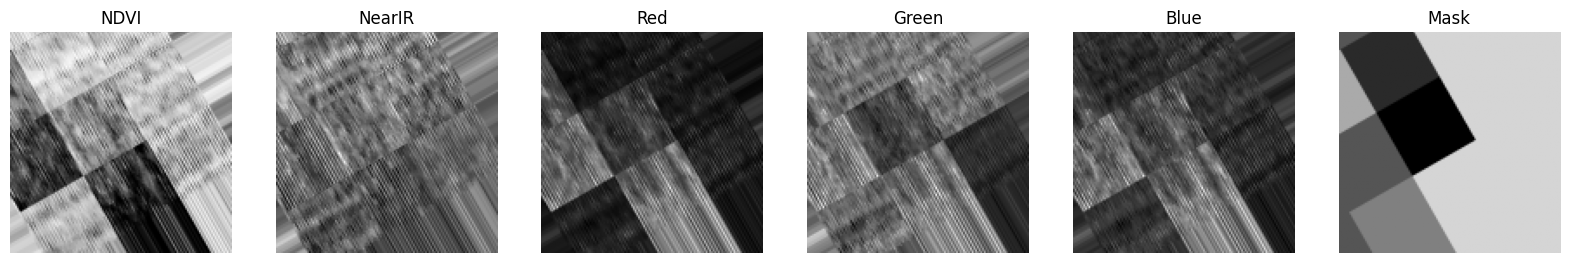

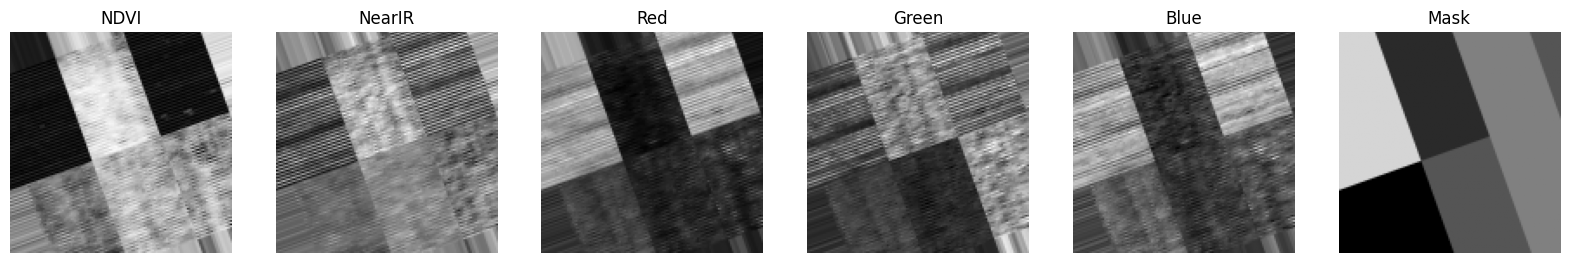

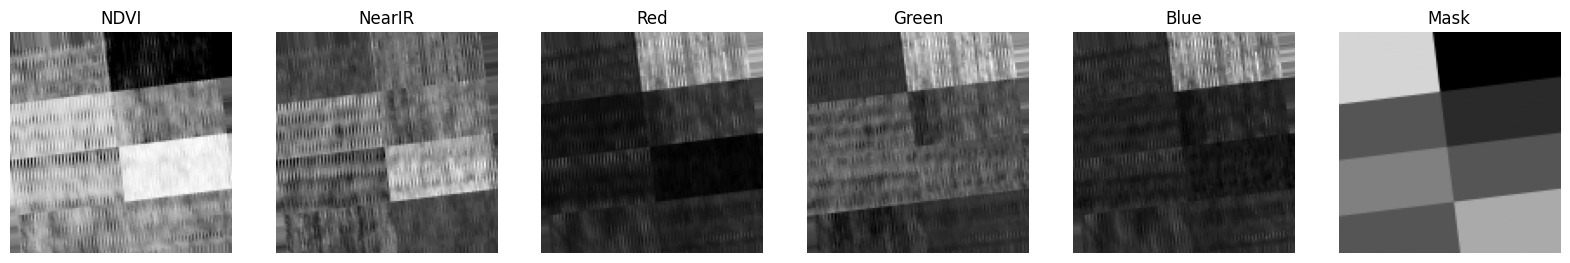

In [15]:
# Названия каналов для подписей
channel_names = ["NDVI", "NearIR", "Red", "Green", "Blue"]

# Получаем один батч
images, masks = next(train_generator)

def visualize_samples(images, masks, num_samples=3):
    """
    Визуализирует несколько примеров изображений и их масок.

    Параметры:
    - images: numpy-массив изображений (размерность: [N, 128, 128, 5])
    - masks: numpy-массив масок (размерность: [N, 128, 128, 1])
    - num_samples: количество примеров для отображения
    """
    for i in range(num_samples):
        img = images[i]  # Берём одно изображение (5 каналов)
        mask = masks[i].squeeze()  # Убираем лишнюю ось (128, 128)

        fig, ax = plt.subplots(1, 6, figsize=(20, 5))

        # Визуализируем все 5 каналов с подписями
        for j in range(5):
            ax[j].imshow(img[:, :, j], cmap="gray")
            ax[j].set_title(channel_names[j])  # Добавляем подпись
            ax[j].axis("Off")

        # Визуализируем маску
        ax[-1].imshow(mask, cmap="gray", vmin=0, vmax=6)
        ax[-1].set_title("Mask")
        ax[-1].axis("Off")

        plt.show()

visualize_samples(images, masks, num_samples=3)

**Проверка валидационных генераторов и визуализация изображений и масок**

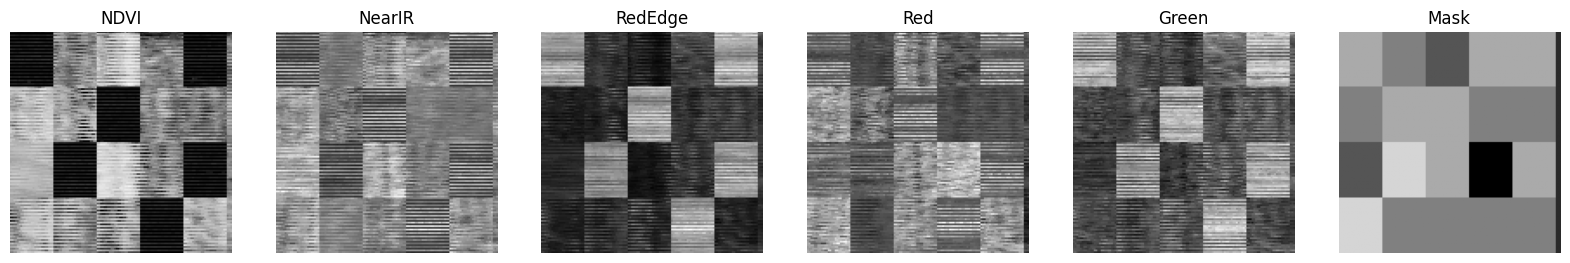

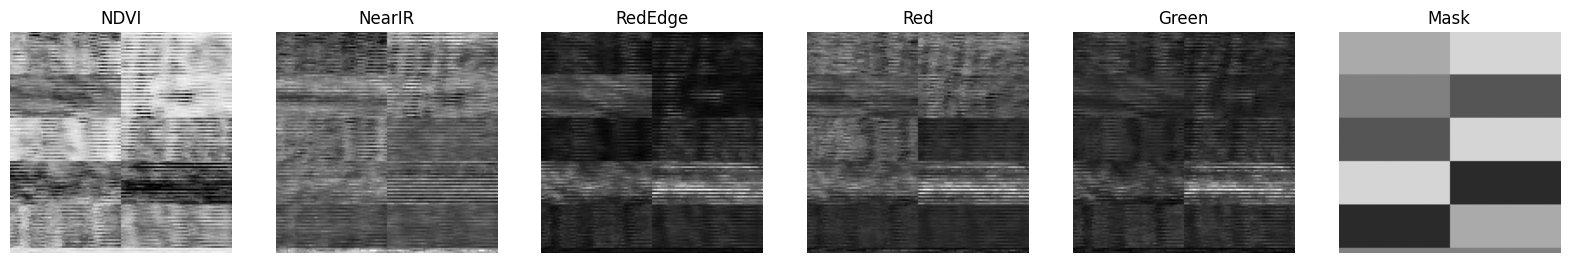

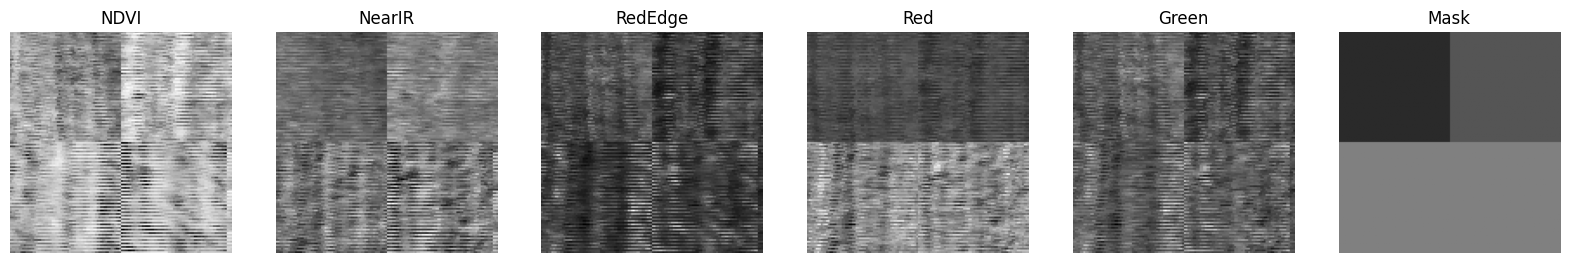

In [12]:
# Названия каналов для подписей
channel_names = ["NDVI", "NearIR", "RedEdge", "Red", "Green", "Blue"]

# Получаем один батч
sample_batch = next(val_generator)
images, masks = sample_batch

def visualize_samples(images, masks, num_samples=3):
    """
    Визуализирует несколько примеров изображений и их масок.

    Параметры:
    - images: numpy-массив изображений (размерность: [N, 128, 128, 5])
    - masks: numpy-массив масок (размерность: [N, 128, 128, 1])
    - num_samples: количество примеров для отображения
    """
    for i in range(num_samples):
        img = images[i]  # Берём одно изображение (5 каналов)
        mask = masks[i].squeeze()  # Убираем лишнюю ось (128, 128)

        fig, ax = plt.subplots(1, 6, figsize=(20, 5))

        # Визуализируем все 5 каналов с подписями
        for j in range(5):
            ax[j].imshow(img[:, :, j], cmap="gray")
            ax[j].set_title(channel_names[j])  # Добавляем подпись
            ax[j].axis("Off")

        # Визуализируем маску
        ax[-1].imshow(mask, cmap="gray", vmin=0, vmax=6)
        ax[-1].set_title("Mask")
        ax[-1].axis("Off")

        plt.show()

visualize_samples(images, masks, num_samples=3)

К данным из валидационной выборки аугментация не применяется

**Подключение к графическому процессору для обучения нейросетей**

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**Архитектура U-Net**

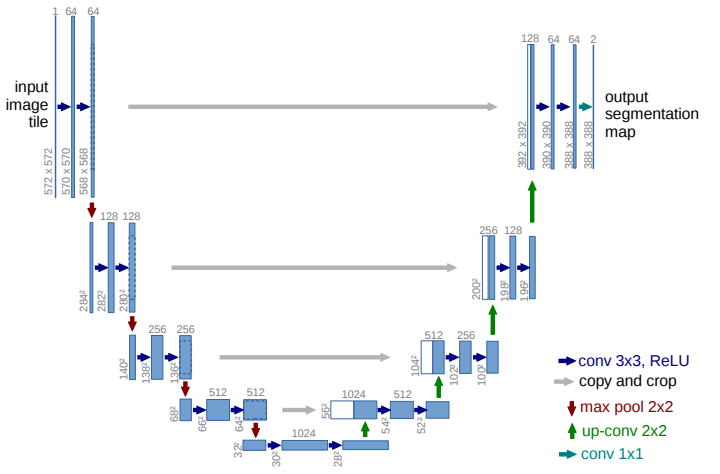

In [12]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)

In [13]:
class UNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    super(UNet, self).__init__()
    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):

    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)

      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

**Тест архитектуры**

In [14]:
def test():
  x = torch.randn((3, 1, 161, 161))
  model = UNet(in_channels=1, out_channels=1)
  preds = model(x)
  assert preds.shape == x.shape

test()

**Функция обучения**

In [15]:
def train(model, opt, loss_fn, epochs, train_generator, val_generator, test_generator, steps_per_epoch, val_steps, test_steps):
    """
    Обучает модель на основе переданных параметров.

    Аргументы:
    - model: нейросеть (torch.nn.Module)
    - opt: оптимизатор (torch.optim)
    - loss_fn: функция потерь
    - epochs: количество эпох
    - train_generator: генератор тренировочных данных
    - val_generator: генератор валидационных данных
    - steps_per_epoch: количество итераций за эпоху обучения
    - val_steps: количество итераций для валидации

    Возвращает:
    - train_losses: список значений функции потерь на обучении
    - val_losses: список значений функции потерь на валидации
    - train_ious: список значений IoU на обучении
    - val_ious: список значений IoU на валидации
    """
    train_losses, val_losses, test_losses = [], [], []
    train_metrics, val_metrics, test_metrics = [], [], []

    # Выбираем метрику: IoU или Accuracy
    metric_cls = Accuracy
    train_metric = metric_cls(task="multiclass", num_classes=6).to(device)
    val_metric = metric_cls(task="multiclass", num_classes=6).to(device)
    test_metric = metric_cls(task="multiclass", num_classes=6).to(device)

    # Планировщик обучения для уменьшения LR, если метрика не улучшается
    scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3, verbose=True)

    # Извлекаем один batch для визуализации
    X_vis, y_vis = next(val_generator)
    X_vis, y_vis = torch.tensor(X_vis), torch.tensor(y_vis)
    X_vis = X_vis.permute(0, 3, 1, 2)  # Меняем порядок осей (H, W, C -> C, H, W)
    y_vis = y_vis.squeeze(dim=3)  # Убираем лишнюю размерность

    for epoch in range(epochs):
        print('Epoch %d/%d' % (epoch+1, epochs))
        train_loss = 0
        model.train()
        train_metric.reset()

        # Обучение модели
        for _ in tqdm(range(steps_per_epoch), desc='Training'):
            X_batch, y_batch = next(train_generator)
            X_batch = torch.tensor(X_batch).permute(0, 3, 1, 2).to(device)
            y_batch = torch.tensor(y_batch).squeeze(dim=3).long().to(device)

            opt.zero_grad()  # Обнуляем градиенты
            y_pred = model(X_batch)  # Предсказание модели
            loss = loss_fn(y_pred, y_batch)  # Вычисление функции потерь
            loss.backward()  # Обратное распространение ошибки
            opt.step()  # Обновление весов

            train_loss += loss.item() / steps_per_epoch
            preds = torch.argmax(y_pred, dim=1)  # Преобразуем в классы
            train_metric.update(preds, y_batch)

        # Сохраняем метрики
        train_losses.append(train_loss)
        train_metrics.append(train_metric.compute().item())
        print(f'Train loss: {train_loss:.4f} | Train metric: {train_metrics[-1]:.4f}')

        # Валидация модели
        model.eval()
        val_loss = 0
        val_metric.reset()
        with torch.no_grad():
            for _ in range(val_steps):
                X_val, y_val = next(val_generator)
                X_val = torch.tensor(X_val).permute(0, 3, 1, 2).to(device)
                y_val = torch.tensor(y_val).squeeze(dim=3).long().to(device)

                y_pred = model(X_val)
                val_loss += loss_fn(y_pred, y_val).item() / val_steps
                y_pred = torch.argmax(y_pred, dim=1)
                val_metric.update(y_pred, y_val)

        val_losses.append(val_loss)
        val_metrics.append(val_metric.compute().item())
        print(f'Validation loss: {val_loss:.4f} | Validation metric: {val_metrics[-1]:.4f}')

        # Тест модели
        test_loss = 0
        test_metric.reset()
        with torch.no_grad():
            for _ in range(test_steps):
                X_test, y_test = next(test_generator)
                X_test = torch.tensor(X_test).permute(0, 3, 1, 2).to(device)
                y_test = torch.tensor(y_test).squeeze(dim=3).long().to(device)

                y_pred = model(X_test)
                test_loss += loss_fn(y_pred, y_test).item() / test_steps
                y_pred = torch.argmax(y_pred, dim=1)
                test_metric.update(y_pred, y_test)

        test_losses.append(test_loss)
        test_metrics.append(test_metric.compute().item())
        print(f'Test loss: {test_loss:.4f} | Test metric: {test_metrics[-1]:.4f}')

        # Адаптивное изменение learning rate
        scheduler.step(val_loss)

        # Визуализация сегментации
        X_vis = X_vis.to(device)
        y_vis = y_vis.to(device)
        y_vis = y_vis.long()

        with torch.no_grad():
            y_pred_vis = model(X_vis)
            y_pred_vis = torch.argmax(y_pred_vis, dim=1).cpu()

        X_vis = X_vis.cpu()
        y_vis = y_vis.cpu()

        clear_output(wait=True)
        fig, ax = plt.subplots(3, 6, figsize=(9, 6))
        fig.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, val_loss))

        for i in range(6):
            img = X_vis[i][0].numpy()
            ax[0, i].imshow(img, cmap='gray')
            ax[0, i].axis('Off')
            ax[0, i].set_title('Input')

            ax[1, i].imshow(y_vis[i].numpy(), cmap='gray', vmin=0, vmax=6)
            ax[1, i].axis('Off')
            ax[1, i].set_title('Real mask')

            ax[2, i].imshow(y_pred_vis[i].numpy(), cmap='gray', vmin=0, vmax=6)
            ax[2, i].axis('Off')
            ax[2, i].set_title('Predicted mask')

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

    # Графики потерь и IoU
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_metrics, label=f'Train metric')
    plt.plot(val_metrics, label=f'Validation metric')
    plt.plot(test_metrics, label=f'Test metric')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    plt.title('Metric')

    plt.tight_layout()
    plt.show()

    return model, train_losses, val_losses, test_losses, train_metrics, val_metrics, test_metrics

In [16]:
# Вычисляем количество шагов (batch-ов) на каждую эпоху
steps_per_epoch = math.ceil(X_train.shape[0] / 32)  # Количество batch-ов в обучающем наборе
val_steps = math.ceil(X_val.shape[0] / 32)  # Количество batch-ов валидации
test_steps = math.ceil(X_test.shape[0] / 32)  # Количество batch-ов для тестирования

In [17]:
# Функция потерь — кросс-энтропия, подходит для многоклассовой сегментации
loss = nn.CrossEntropyLoss()

In [18]:
def train_model(model, max_epochs, loss, train_generator, val_generator, test_generator, lr=1e-4):
    """
    Подготавливает и обучает модель U-Net для сегментации изображений.

    Аргументы:
    - model: обучаемая модель
    - max_epochs: количество эпох обучения
    - train_generator: генератор тренировочных данных
    - val_generator: генератор валидационных данных
    - lr: скорость обучения (learning rate), по умолчанию 1e-4

    Возвращает:
    - train_losses: список значений функции потерь на обучении
    - val_losses: список значений функции потерь на валидации
    - train_ious: список значений IoU на обучении
    - val_ious: список значений IoU на валидации
    """

    # Оптимизатор Adam для обновления весов модели
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Запуск процесса обучения модели
    return train(model, opt, loss, max_epochs, train_generator, val_generator, test_generator, steps_per_epoch, val_steps, test_steps)

**Функция для получения результатов и метрики на тестовых данных**

In [19]:
def evaluate_on_test(model, loss_fn, test_generator, test_steps):
    # Создаём метрику для многоклассовой сегментации
    metric_cls = Accuracy
    test_metric = metric_cls(task="multiclass", num_classes=6).to(device)

    # Переводим модель в режим оценки
    model.eval()
    test_loss = 0  # Не используется
    test_metric.reset()  # Сбрасываем метрику перед оценкой

    # Отключаем градиенты
    with torch.no_grad():
        for step in range(test_steps):  # Пробегаем по всем батчам тестового набора
            X_test, y_test = next(test_generator)  # Получаем входные данные и метки
            # Преобразуем данные в тензоры, переставляем каналы (H, W, C -> C, H, W)
            X_test = torch.tensor(X_test).permute(0, 3, 1, 2).to(device)
            y_test = torch.tensor(y_test).squeeze(dim=3).to(device)  # Убираем лишнюю размерность
            y_test = y_test.long()  # Приводим метки к целочисленному типу

            # Прогоняем изображения через модель
            y_pred = model(X_test)

            # Получаем предсказания классов
            y_pred = torch.argmax(y_pred, dim=1)

            # Обновляем метрику IoU
            test_metric.update(y_pred, y_test)

            # Берём данные для визуализации только на первом шаге
            if step == 0:
                X_vis, y_vis = X_test, y_test  # Копируем первый батч для визуализации

    # # Визуализация нескольких примеров предсказаний
    # X_vis, y_vis = next(test_generator)  # Берём ещё один батч для визуализации
    # X_vis = torch.tensor(X_vis).permute(0, 3, 1, 2).to(device)
    # y_vis = torch.tensor(y_vis).squeeze(dim=3).to(device)
    # y_vis = y_vis.long()

    with torch.no_grad():
        y_pred_vis = model(X_vis)  # Делаем предсказание
        y_pred_vis = torch.argmax(y_pred_vis, dim=1).cpu()

    X_vis = X_vis.cpu()
    y_vis = y_vis.cpu()

    clear_output(wait=True)  # Очищаем вывод в блокноте (для обновления графиков)
    fig, ax = plt.subplots(3, 6, figsize=(9, 6))

    for i in range(6):  # Отображаем первые 6 примеров из батча
        img = X_vis[i][0].numpy()  # Извлекаем изображение

        ax[0, i].imshow(img, cmap='gray')  # Исходное изображение
        ax[0, i].axis('Off')
        ax[0, i].set_title('Input')

        ax[1, i].imshow(y_vis[i].numpy(), cmap='gray', vmin=0, vmax=6)  # Реальная разметка
        ax[1, i].axis('Off')
        ax[1, i].set_title('Real mask')

        ax[2, i].imshow(y_pred_vis[i].numpy(), cmap='gray', vmin=0, vmax=6)  # Предсказанная маска
        ax[2, i].axis('Off')
        ax[2, i].set_title('Predicted mask')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Вычисляем итоговую метрику IoU по тестовому набору
    test_accuracy = test_metric.compute().item()
    print('Test Accuracy: %f' % test_accuracy)

    return test_accuracy

**Эксперименты с обучением модели U-Net на разном количестве эпох**

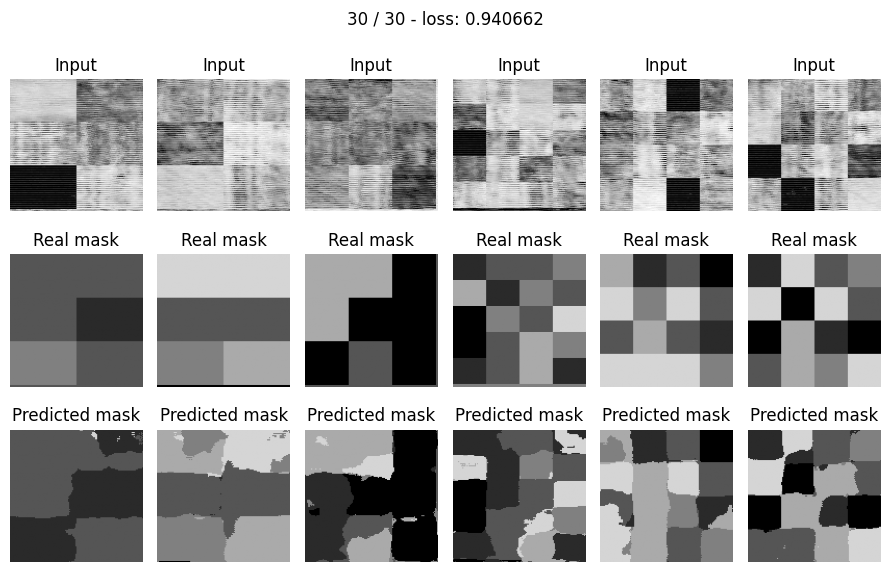

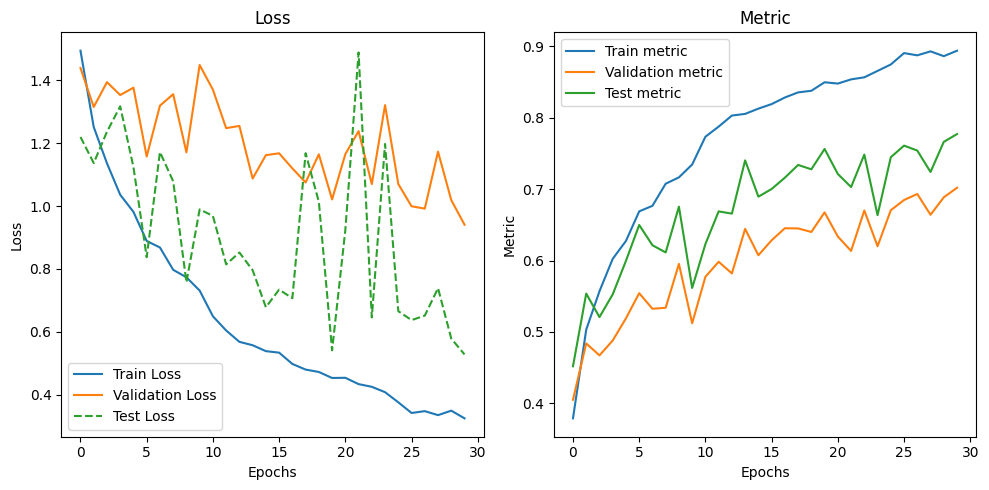

In [20]:
# Инициализация модели U-Net с 5 входными каналами (спектры) и 6 выходными классами
model_UNet = UNet(in_channels=5, out_channels=6).to(device)

train_data = train_model(model=model_UNet, max_epochs=30, loss=loss, train_generator=train_generator, val_generator=val_generator, test_generator=test_generator, lr=1e-4)

**30 epochs**

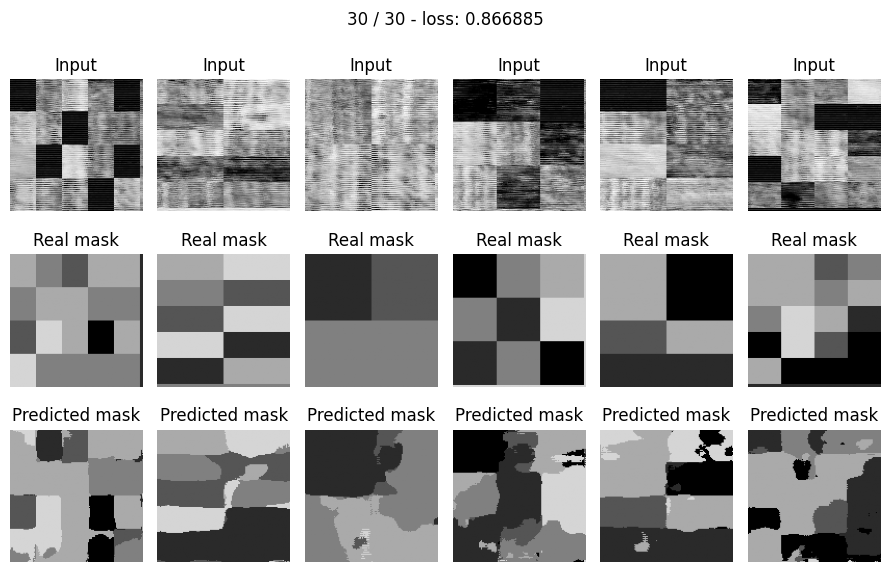

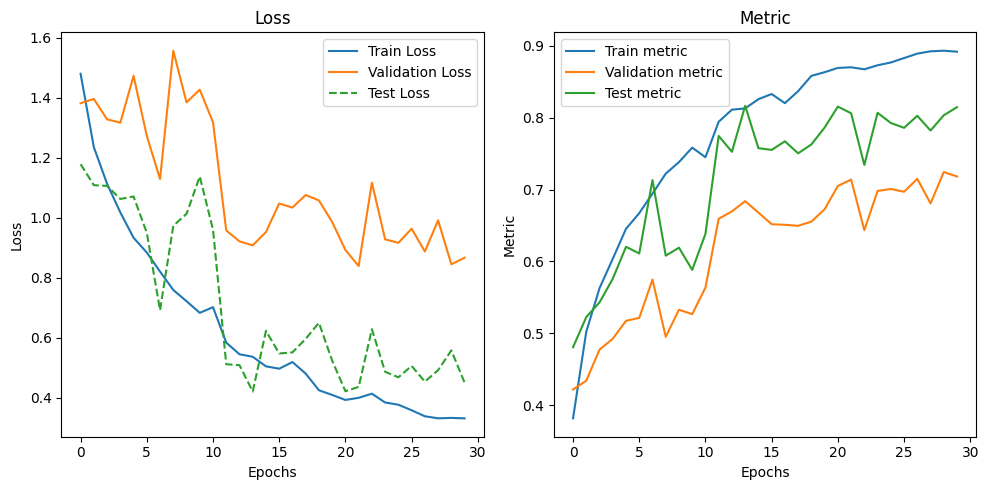

In [27]:
# Инициализация модели U-Net с 5 входными каналами (спектры) и 6 выходными классами
model_UNet = UNet(in_channels=5, out_channels=6).to(device)

train_data = train_model(model=model_UNet, max_epochs=30, loss=loss, train_generator=train_generator, val_generator=val_generator, test_generator=test_generator, lr=1e-4)

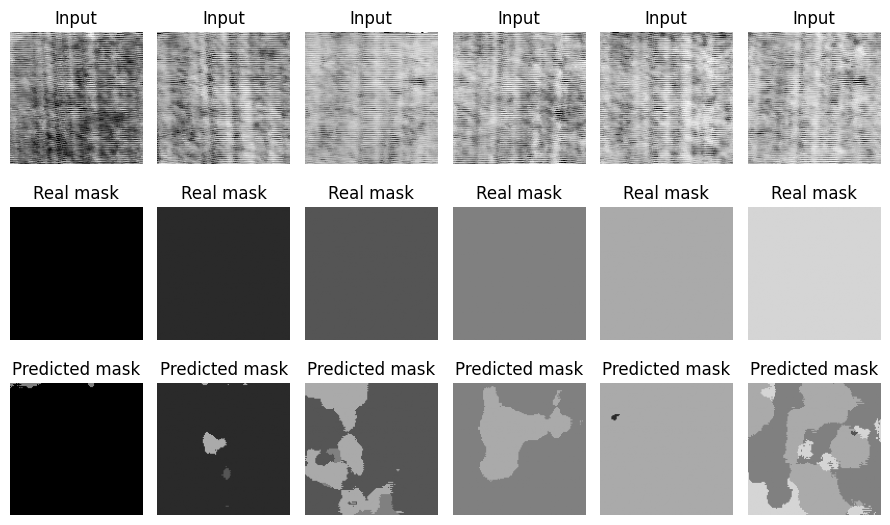

Test Accuracy: 0.777198


In [21]:
test = evaluate_on_test(model_UNet, loss, test_generator, test_steps)

**50 epochs**

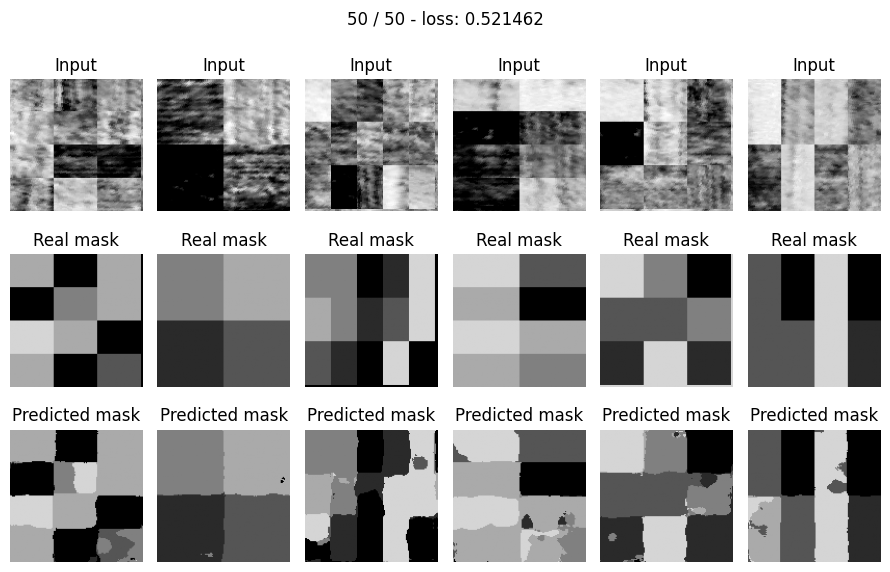

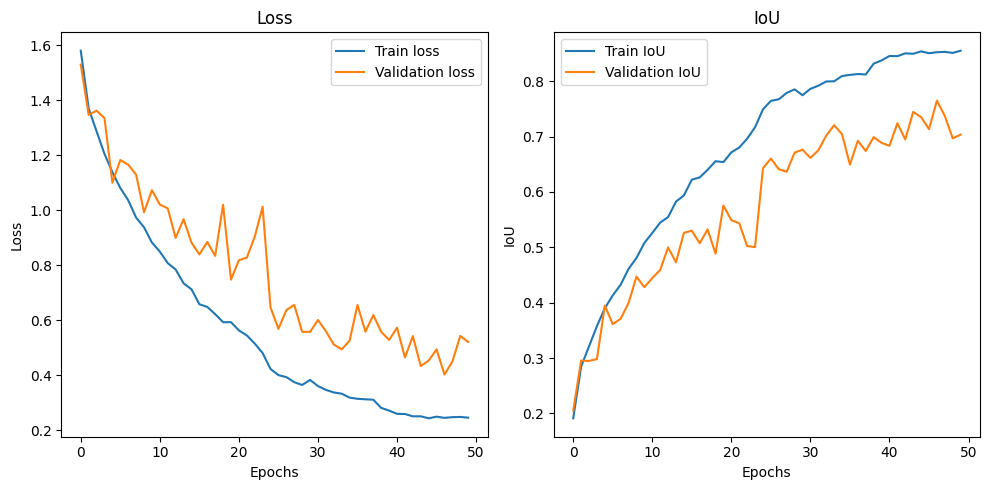

In [ ]:
# Инициализация модели U-Net с 6 входными каналами (спектры) и 6 выходными классами
model_UNet = UNet(in_channels=5, out_channels=6).to(device)

train_data = train_model(model=model_UNet, max_epochs=50, loss=loss, train_generator=train_generator, val_generator=val_generator, lr=1e-4)

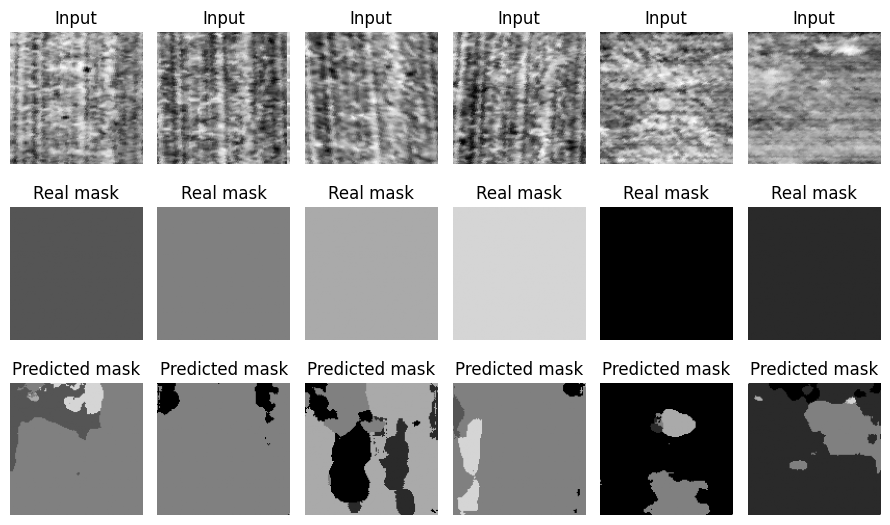

Test Accuracy: 0.263869


In [ ]:
test = evaluate_on_test(model_UNet, loss, test_generator, test_steps)

Что-то не так, модель переобучается.

**Архитектура U-Net++**

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class Up(nn.Module):

    def __init__(self):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x


class NestedUNet(nn.Module):
    def __init__(self, num_classes=1, input_channels=1, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = Up()

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(self.up(x1_0, x0_0))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(self.up(x2_0, x1_0))
        x0_2 = self.conv0_2(self.up(x1_1, torch.cat([x0_0, x0_1], 1)))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(self.up(x3_0, x2_0))
        x1_2 = self.conv1_2(self.up(x2_1, torch.cat([x1_0, x1_1], 1)))
        x0_3 = self.conv0_3(self.up(x1_2, torch.cat([x0_0, x0_1, x0_2], 1)))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(self.up(x4_0, x3_0))
        x2_2 = self.conv2_2(self.up(x3_1, torch.cat([x2_0, x2_1], 1)))
        x1_3 = self.conv1_3(self.up(x2_2, torch.cat([x1_0, x1_1, x1_2], 1)))
        x0_4 = self.conv0_4(self.up(x1_3, torch.cat([x0_0, x0_1, x0_2, x0_3], 1)))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

**Тест архитектуры**

In [ ]:
def test_model():
    batch_size = 4
    input_channels = 6
    height, width = 128, 128
    num_classes = 6
    deep_supervision = False

    input_tensor = torch.randn(batch_size, input_channels, height, width)
    model = NestedUNet(num_classes=num_classes, input_channels=input_channels, deep_supervision=deep_supervision)
    output = model(input_tensor)

    if deep_supervision:
        print(f'Количество выходов: {len(output)}')
        for i, out in enumerate(output):
            print(f'Размер выходных данных {i+1}: {out.size()}')
    else:
        print(f'Размер выходных данных: {output.size()}')

test_model()

Размер выходных данных: torch.Size([4, 6, 128, 128])


**Эксперимент с разным количеством эпох**

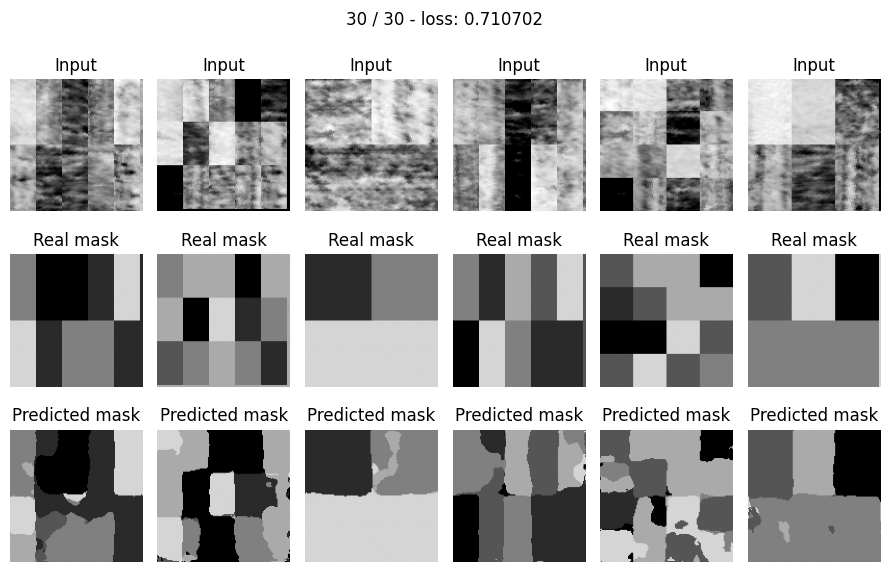

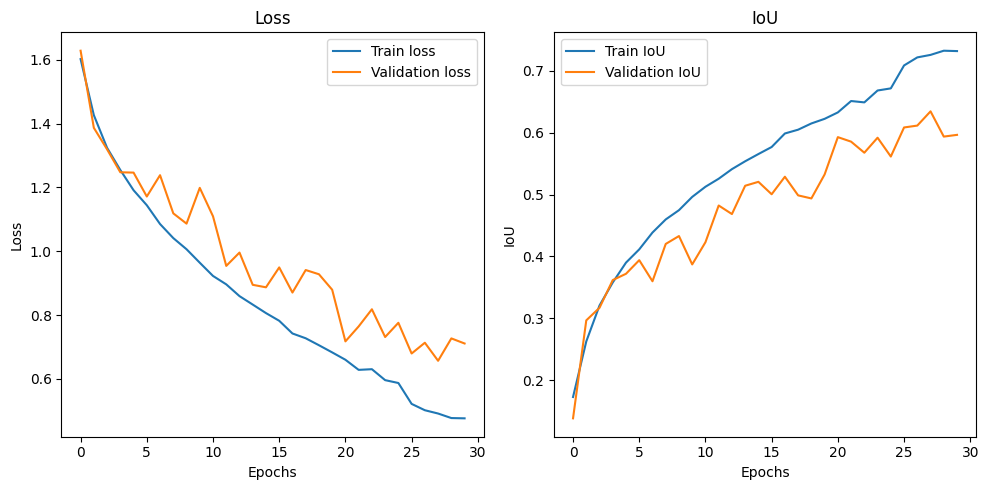

In [ ]:
# Инициализация модели U-Net++ с 5 входными каналами (спектры) и 6 выходными классами
model_Nested = NestedUNet(num_classes=6, input_channels=5).to(device)

train_data = train_model(model=model_Nested, max_epochs=30, loss=loss, train_generator=train_generator, val_generator=val_generator, lr=1e-4)

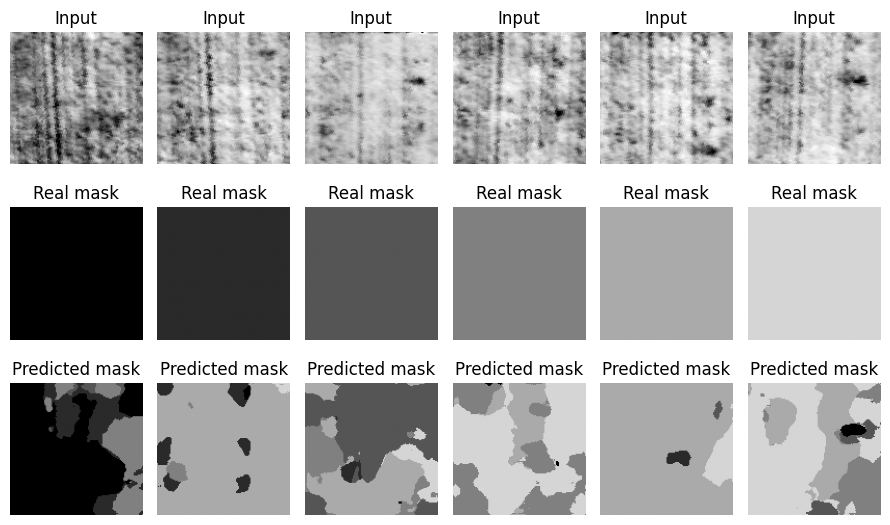

Test Accuracy: 0.260621


In [ ]:
test = evaluate_on_test(model_Nested, loss, test_generator, test_steps)

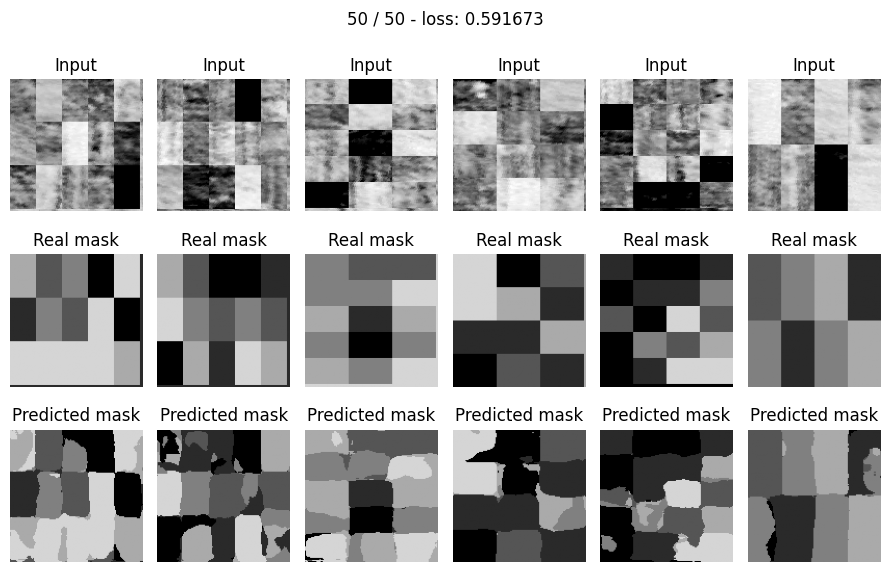

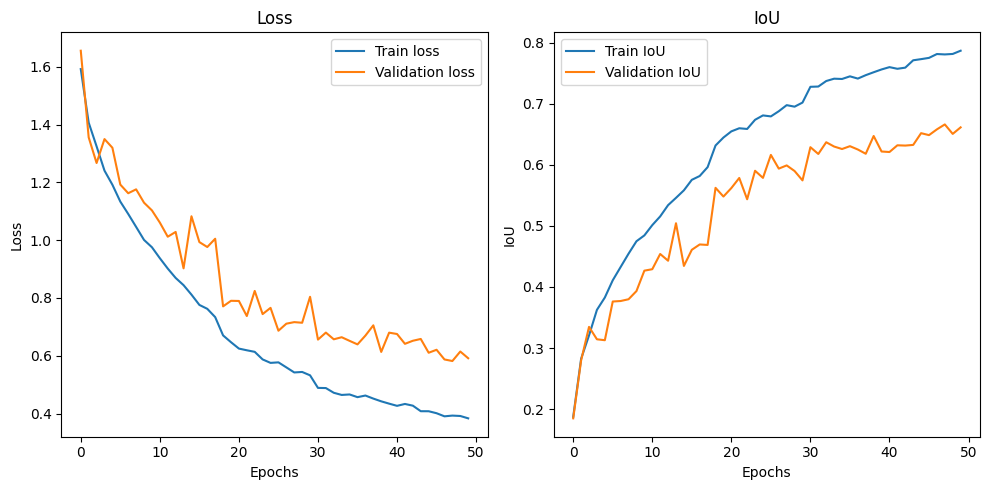

In [ ]:
# Инициализация модели U-Net++ с 5 входными каналами (спектры) и 6 выходными классами
model_Nested = NestedUNet(num_classes=6, input_channels=5).to(device)

train_data = train_model(model=model_Nested, max_epochs=50, loss=loss, train_generator=train_generator, val_generator=val_generator, lr=1e-4)

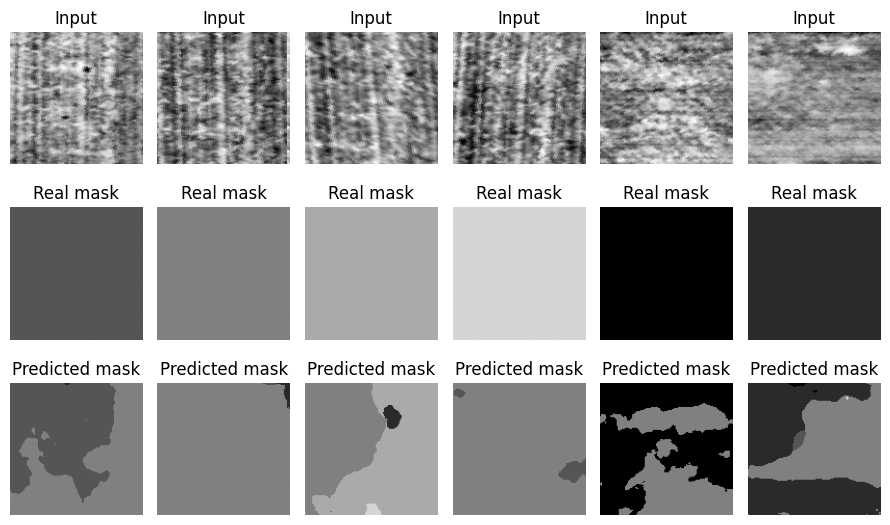

Test Accuracy: 0.272301


In [ ]:
test = evaluate_on_test(model_Nested, loss, test_generator, test_steps)

Здесь тоже переобучение.

**Архитектура SegNet**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_channels):
        super(Encoder, self).__init__()

        self.enco1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enco2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.enco3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.enco4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.enco5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

    def forward(self, x):
        id = []
        x = self.enco1(x)
        x, id1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id1)
        x = self.enco2(x)
        x, id2 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id2)
        x = self.enco3(x)
        x, id3 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id3)
        x = self.enco4(x)
        x, id4 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id4)
        x = self.enco5(x)
        x, id5 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id5)
        return x, id

class SegNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SegNet, self).__init__()

        self.encoder = Encoder(input_channels)

        self.deco1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.deco2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.deco3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.deco4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.deco5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, output_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x, id = self.encoder(x)
        x = F.max_unpool2d(x, id[4], kernel_size=2, stride=2)
        x = self.deco1(x)
        x = F.max_unpool2d(x, id[3], kernel_size=2, stride=2)
        x = self.deco2(x)
        x = F.max_unpool2d(x, id[2], kernel_size=2, stride=2)
        x = self.deco3(x)
        x = F.max_unpool2d(x, id[1], kernel_size=2, stride=2)
        x = self.deco4(x)
        x = F.max_unpool2d(x, id[0], kernel_size=2, stride=2)
        x = self.deco5(x)

        return x

**Тест архитектуры**

In [ ]:
def test_model():
    input_tensor = torch.randn(4, 6, 256, 256)
    model = SegNet(input_channels=6, output_channels=6)
    output = model(input_tensor)
    print(f"Размер выходных данных: {output.shape}")

test_model()

Размер выходных данных: torch.Size([4, 6, 256, 256])


**Эксперимент с разным количеством эпох**

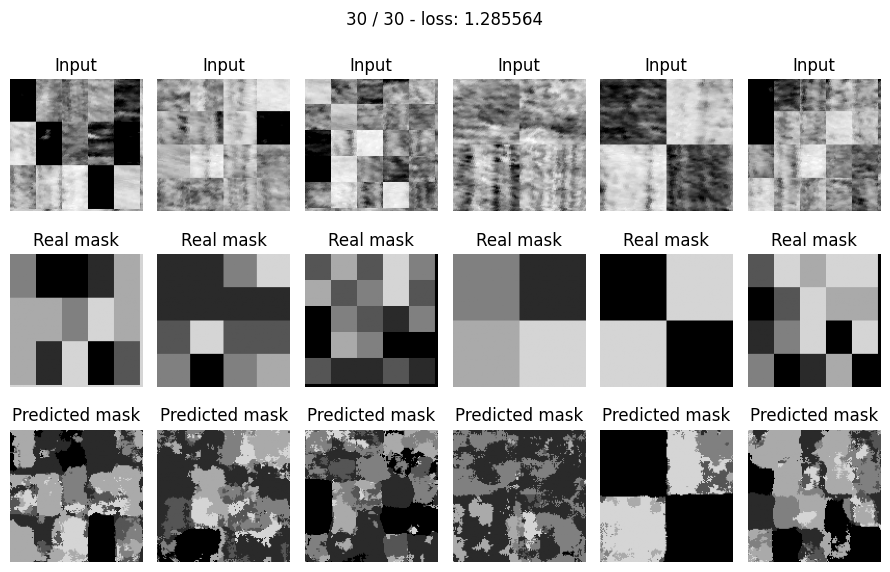

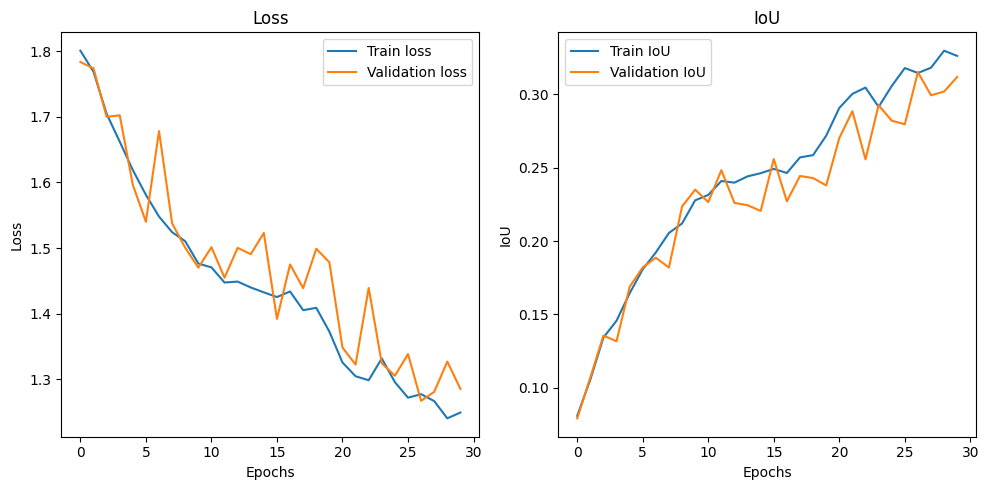

In [ ]:
# Инициализация модели SegNet с 6 входными каналами (спектры) и 6 выходными классами
model_SegNet = SegNet(input_channels=5, output_channels=6).to(device)

train_data = train_model(model=model_SegNet, max_epochs=30, loss=loss, train_generator=train_generator, val_generator=val_generator, lr=1e-4)

IndexError: index 2 is out of bounds for dimension 0 with size 2

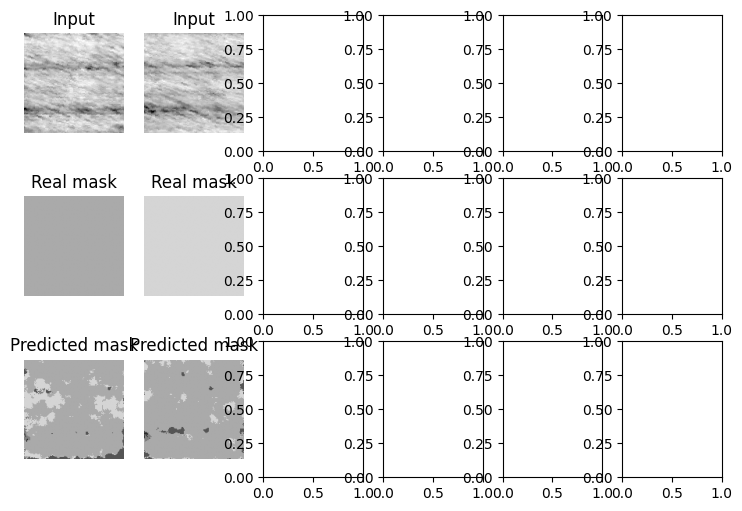

In [ ]:
test = evaluate_on_test(model_SegNet, loss, test_generator, test_steps)

In [ ]:
# Инициализация модели SegNet с 5 входными каналами (спектры) и 6 выходными классами
model_SegNet = SegNet(input_channels=5, output_channels=6).to(device)

train_data = train_model(model=model_SegNet, max_epochs=50, loss=loss, train_generator=train_generator, val_generator=val_generator, lr=1e-4)

In [ ]:
test = evaluate_on_test(model_SegNet, loss, test_generator, test_steps)

SegNet в целом медленно обучается, но переобучение также присутствует.